In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [10]:
# Load the data
file = 'C:/dev/research/temp/handson-unsupervised-learning/datasets/LoanStats3a.csv'
data = pd.read_csv(file)

C:\Users\JeffChow\AppData\Local\conda\conda\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
type(data)

pandas.core.frame.DataFrame

In [12]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

In [13]:
data.shape

(42542, 145)

In [14]:

# Select columns to keep
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]

In [15]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


In [16]:
data.dtypes

loan_amnt                  float64
funded_amnt                float64
funded_amnt_inv            float64
term                        object
int_rate                    object
installment                float64
grade                       object
sub_grade                   object
emp_length                  object
home_ownership              object
annual_inc                 float64
verification_status         object
pymnt_plan                  object
purpose                     object
addr_state                  object
dti                        float64
delinq_2yrs                float64
earliest_cr_line            object
mths_since_last_delinq     float64
mths_since_last_record     float64
open_acc                   float64
pub_rec                    float64
revol_bal                  float64
revol_util                  object
total_acc                  float64
initial_list_status         object
out_prncp                  float64
out_prncp_inv              float64
total_pymnt         

In [18]:
c# Take a look at the non numeric features
non_numeric_teatures = ["term","int_rate","emp_length","revol_util"]
non_numeric_data = data.loc[:, non_numeric_teatures]

print(non_numeric_data.head(10))

         term int_rate emp_length revol_util
0   36 months   10.65%  10+ years     83.70%
1   60 months   15.27%   < 1 year      9.40%
2   36 months   15.96%  10+ years     98.50%
3   36 months   13.49%  10+ years        21%
4   60 months   12.69%     1 year     53.90%
5   36 months    7.90%    3 years     28.30%
6   60 months   15.96%    8 years     85.60%
7   36 months   18.64%    9 years     87.50%
8   60 months   21.28%    4 years     32.60%
9   60 months   12.69%   < 1 year     36.50%


In [19]:
# Let's remove the alphabetical part

for i in non_numeric_teatures:
    data.loc[:,i] = data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])
    

In [21]:
numericalFeatures = [x for x in data.columns if data[x].dtype != 'object']

In [23]:
check_nan = np.isnan(data.loc[:,numericalFeatures]).sum()
check_nan

loan_amnt                      7
funded_amnt                    7
funded_amnt_inv                7
term                           7
int_rate                       7
installment                    7
emp_length                  1119
annual_inc                    11
dti                            7
delinq_2yrs                   36
mths_since_last_delinq     26933
mths_since_last_record     38891
open_acc                      36
pub_rec                       36
revol_bal                      7
revol_util                    97
total_acc                     36
out_prncp                      7
out_prncp_inv                  7
total_pymnt                    7
total_pymnt_inv                7
total_rec_prncp                7
total_rec_int                  7
total_rec_late_fee             7
recoveries                     7
collection_recovery_fee        7
last_pymnt_amnt                7
dtype: int64

In [24]:
## Imputation - follow the reference source

# Impute NaNs with mean 
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation
im = pp.Imputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

In [26]:
check_nan = np.isnan(data.loc[:,numericalFeatures]).sum()
check_nan

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

In [28]:
# Add additional features that are derived from the original ones - usually from business perspective

data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeatures = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

In [39]:

# Select features for training
finalFeatures = numericalFeatures + newFeatures
pd_X_train = data.loc[:,finalFeatures]

# Scale data
sX = pp.StandardScaler()
pd_X_train.loc[:,:] = sX.fit_transform(pd_X_train)

In [40]:
pd_X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

In [35]:
labels = data.grade
labels.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [36]:
labels = labels.fillna(value='Z')

In [41]:
# Convert labels to numerical values
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
pd_y_train = pd.Series(data=lbl.transform(labels.values), name="grade")

In [42]:
pd_y_train.head()

0    1
1    2
2    2
3    2
4    1
Name: grade, dtype: int64

In [47]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster_index'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster_index','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster_index']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster_index').agg(lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster_index','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, left_on="cluster_index",right_on="cluster_index")
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

### K-Means

In [59]:
## No PCA for pd_X_train
from sklearn.cluster import KMeans

def get_overall_accuracy(n, pd_X, pd_y, pd_inertia, pd_overallAccuracy):
    
    n_clusters = n
    n_init = 10
    max_iter = 300
    tol = 0.0001
    random_state = 2019
    n_jobs = 2
    
    
    kmeans = KMeans(n_clusters=n_clusters, \
                    n_init=n_init, \
                    max_iter=max_iter, \
                    tol=tol, \
                    random_state=random_state,\
                    n_jobs=n_jobs)

    kmeans.fit(pd_X)
    pd_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(pd_X)
    X_train_kmeansClustered = pd.DataFrame(data= X_train_kmeansClustered, index=pd_X.index, columns=['cluster_index'])
    
    countByCluster_kMeans, countByLabel_kMeans, \
    countMostFreq_kMeans, accuracyDF_kMeans, \
    overallAccuracy_kMeans, accuracyByLabel_kMeans = \
    analyzeCluster(X_train_kmeansClustered, pd_y)
    
    pd_overallAccuracy.loc[n_clusters] = overallAccuracy_kMeans
    return accuracyByLabel_kMeans

In [60]:
## Experiement with number of clusters from 10 to 32 

r = range(10,40)

overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=r,columns=['overallAccuracy'])
kMeans_inertia = pd.DataFrame(data=[], index=r, columns=['inertia'])

for n in r:
    accuracyByLabel_kMeans = get_overall_accuracy(n, pd_X_train, pd_y_train, kMeans_inertia, overallAccuracy_kMeansDF)


In [54]:
overallAccuracy_kMeansDF.head()

,overallAccuracy
10,0.329345
11,0.330403
12,0.334705
13,0.337572
14,0.36813


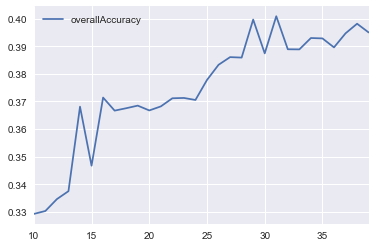

In [61]:
overallAccuracy_kMeansDF.plot()

In [ ]:
### The accuracy for individual cluster might perform better. 

In [62]:
accuracyByLabel_kMeans

NameError: name 'accuracyByLabel_kMeans' is not defined

### Hierarchical Clustering

In [63]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

#
# Building the dandrogram. It seems faster than KMeans
#
Z = fastcluster.linkage_vector(pd_X_train, method='ward', metric='euclidean')

Z_dataFrame = pd.DataFrame(data=Z,columns=['clusterOne', \
                'clusterTwo','distance','newClusterSize'])

In [64]:
Z_dataFrame[:10]

,clusterOne,clusterTwo,distance,newClusterSize
0,39786.0,39787.0,0.000000e+00,2.0
1,39788.0,42542.0,0.000000e+00,3.0
2,42538.0,42539.0,0.000000e+00,2.0
3,42540.0,42544.0,0.000000e+00,3.0
4,42541.0,42545.0,3.399350e-17,4.0
5,42543.0,42546.0,5.139334e-17,7.0
6,33251.0,33261.0,1.561313e-01,2.0
7,42512.0,42535.0,3.342654e-01,2.0
8,42219.0,42316.0,3.368231e-01,2.0
9,6112.0,21928.0,3.384368e-01,2.0


In [65]:
Z_dataFrame[42521:]

,clusterOne,clusterTwo,distance,newClusterSize
42521,85038.0,85043.0,132.715723,3969.0
42522,85051.0,85052.0,141.386569,2899.0
42523,85026.0,85027.0,146.976703,2351.0
42524,85048.0,85049.0,152.660192,5691.0
42525,85036.0,85059.0,153.512281,5956.0
42526,85033.0,85044.0,160.825959,2203.0
42527,85055.0,85061.0,163.701428,668.0
42528,85062.0,85066.0,168.199295,6897.0
42529,85054.0,85060.0,168.924039,9414.0
42530,85028.0,85064.0,185.215769,3118.0


In [72]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 120
clusters = fcluster(Z, distance_threshold, criterion='distance')

# The depending on the name of the column is annoying - what is a better way?
X_train_hierClustered = pd.DataFrame(data=clusters, index=X_train.index,columns=['cluster_index'])  

In [73]:
print("Number of distinct clusters: ", len(X_train_hierClustered['cluster_index'].unique()))

Number of distinct clusters:  25


In [76]:
_,_,_,_,overallAccuracy_hierClust, accuracyByLabel_hierClust = analyzeCluster(X_train_hierClustered, pd_y_train)

In [77]:
print("Overall accuracy from hierarchical clustering: ", overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.3547788068261953


In [78]:
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.304124
1     0.219001
2     0.228311
3     0.379722
4     0.248201
5     0.314560
6     0.263930
7     0.277333
8     0.269772
9     0.335717
10    0.330403
11    0.408521
12    0.744155
13    0.502227
14    0.202247
15    0.254727
16    0.241042
17    0.317979
18    0.308771
19    0.250429
20    0.500000
21    0.289157
22    0.339299
23    0.393559
24    0.340875
dtype: float64

### HDBSCAN

In [79]:
import hdbscan

min_cluster_size = 20 # How to decide?
min_samples = 20      # How to decide?
alpha = 1.0           # How to decide?
cluster_selection_method = 'leaf'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, alpha=alpha, \
    cluster_selection_method=cluster_selection_method)

X_train_hdbscanClustered = hdb.fit_predict(pd_X_train)
pd_X_train_hdbscanClustered = pd.DataFrame(data= X_train_hdbscanClustered, index=X_train.index, \
    columns=['cluster_index'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
    analyzeCluster(pd_X_train_hdbscanClustered, pd_y_train)

ModuleNotFoundError: No module named 'hdbscan'